In [1]:
from pathlib import Path
from typing import Dict
from PIL.Image import Image

import torch
import yaml
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_dataset
from models import VAE
from seed import get_seeded_generator, seed_everything, seeded_worker_init_fn
from visualizations import sample, reconstruct

In [2]:
device = torch.device("mps")

In [3]:
models: Dict[int, VAE] = {}

for latent_dim in [2, 4, 8, 16, 32]:
    config = f"configs/VAE/SVHN/latent-dim-ablation/latent_dim={latent_dim}.yaml"
    ckpt = f"checkpoints/SVHN/VAE(latent_dim={latent_dim})/best.ckpt"

    with open(config, "r") as fs:
        config = yaml.safe_load(fs)

    seed_everything(config["training"]["seed"])

    model = VAE(
        image_channels=config["image"]["channels"],
        image_size=(
            config["image"]["size"],
            config["image"]["size"]
        ),
        **config["model"]
    )
    model.load_state_dict(
        torch.load(ckpt, map_location=device)["model_state_dict"]
    )
    model = model.to(device)
    models[latent_dim] = model

In [4]:
train_dataset, test_dataset = get_dataset(
    config["dataset"]["name"],
    Path(config["dataset"]["datasets_dir"]),
    config["image"]["size"]
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=config["training"]["batch_size"],
    worker_init_fn=seeded_worker_init_fn,
    generator=get_seeded_generator(config["training"]["seed"]),
    shuffle=True,
    pin_memory=config["training"]["pin_memory"],
    num_workers=config["training"]["num_workers"],
    prefetch_factor=(
        config["training"]["prefetch_factor"] if config["training"]["prefetch_factor"] else None
    ),
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=config["training"]["batch_size"],
    worker_init_fn=seeded_worker_init_fn,
    generator=get_seeded_generator(config["training"]["seed"]),
    num_workers=config["training"]["num_workers"],
    prefetch_factor=(
        config["training"]["prefetch_factor"] if config["training"]["prefetch_factor"] else None
    ),
)

Using downloaded and verified file: datasets/SVHN/train_32x32.mat
Using downloaded and verified file: datasets/SVHN/test_32x32.mat


In [5]:
reconstructions_per_latent_dim: Dict[int, Image] = {}

for latent_dim, model in models.items():
    reconstructions_per_latent_dim[latent_dim] = reconstruct(
        model,
        config["training"]["num_reconstructions"],
        10,
        config["image"]["channels"],
        config["image"]["size"],
        test_dataloader,
        device
    )

In [6]:
samples_per_latent_dim: Dict[int, Image] = {}

for latent_dim, model in models.items():
    samples_per_latent_dim[latent_dim] = sample(
        model,
        config["training"]["num_samples"],
        device
    )

As the dimension of latent space increases, reconstructions are getting better.

latent_dim=2


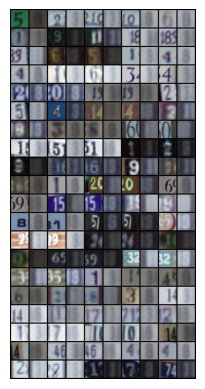

latent_dim=4


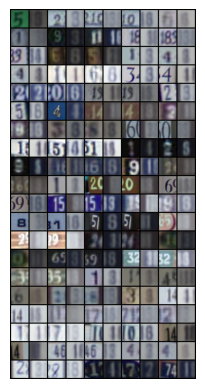

latent_dim=8


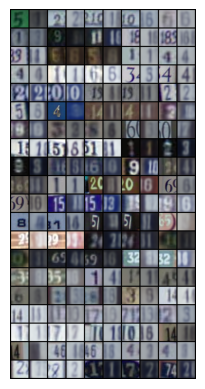

latent_dim=16


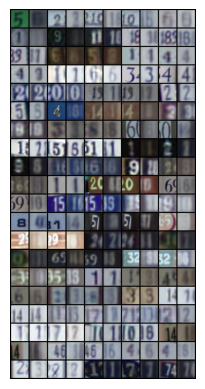

latent_dim=32


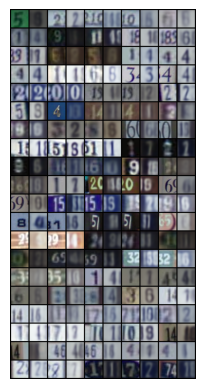

In [7]:
for latent_dim, reconstructions in reconstructions_per_latent_dim.items():
    print(f"latent_dim={latent_dim}")
    plt.imshow(reconstructions)
    plt.axis("off")
    plt.show()

As the dimension of latent space increases, samples are getting clearer and the model is able to generate more colors.

latent_dim=2


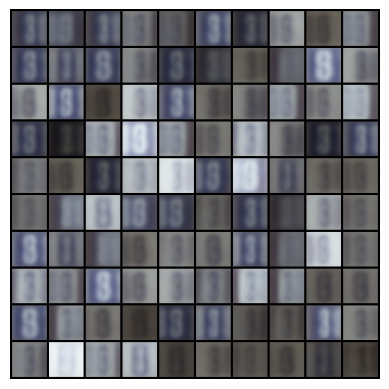

latent_dim=4


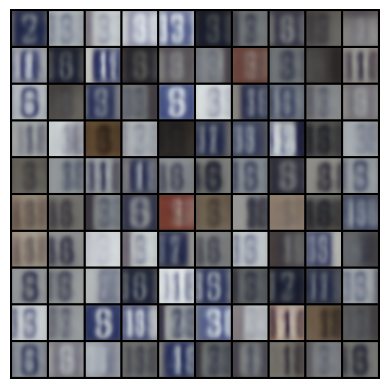

latent_dim=8


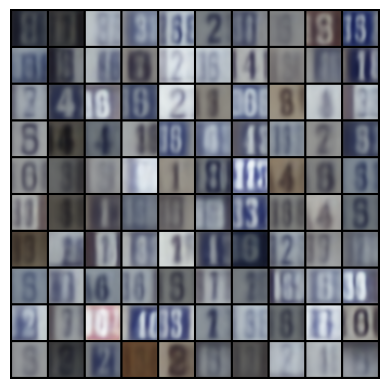

latent_dim=16


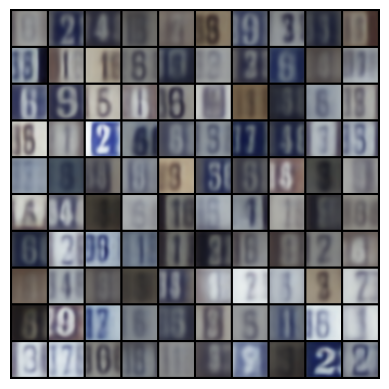

latent_dim=32


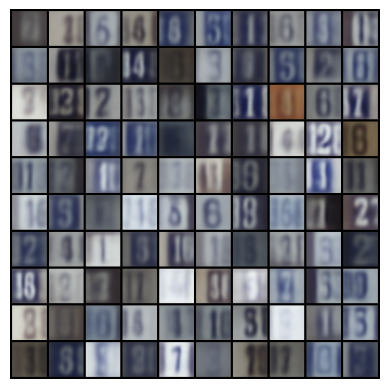

In [8]:
for latent_dim, samples in samples_per_latent_dim.items():
    print(f"latent_dim={latent_dim}")
    plt.imshow(samples)
    plt.axis("off")
    plt.show()